In [1]:
! nvidia-smi

Wed Jan 27 23:24:34 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.102.04   Driver Version: 450.102.04   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 106...  Off  | 00000000:01:00.0  On |                  N/A |
| N/A   64C    P0    25W /  N/A |    453MiB /  6069MiB |      2%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Imports

In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sys

import sklearn
from sklearn.model_selection import StratifiedKFold, KFold, train_test_split

import torch as th 
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import pytorch_lightning as pl 
from pytorch_lightning import seed_everything, Trainer
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, GPUStatsMonitor
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.metrics.functional.classification import accuracy, precision
from pytorch_lightning.metrics.functional import f1

import transformers
from transformers import AutoModel, AutoTokenizer
from transformers import get_linear_schedule_with_warmup, AdamW

from tqdm import tqdm
# Printing stuff

print(f"[INFO] Using pytorch Lightning version {pl.__version__}")
print(f"[INFO] Using pytorch  version {th.__version__}")
print(f"[INFO] Using sklearn version {sklearn.__version__}")
print(f"[INFO] Using transformers version {transformers.__version__}")
print(f"[INFO] Using pandas {pd.__version__}")

%load_ext tensorboard

[INFO] Using pytorch Lightning version 1.0.8
[INFO] Using pytorch  version 1.7.0
[INFO] Using sklearn version 0.23.2
[INFO] Using transformers version 3.5.1
[INFO] Using pandas 1.1.4


In [21]:
import warnings
warnings.filterwarnings(action='ignore')

# Config

In [3]:
class config:
    dataset_path = os.path.abspath('../data')
    working_dir = os.path.abspath('../')
    models_dir = os.path.join(working_dir, 'models')
    submissions_dir = os.path.join(working_dir, 'submissions')
    logs_dir = os.path.join(working_dir, 'logs')
    max_len = 115
    base_model = 'distilbert-base-uncased'
    train_batch_size = 32
    test_batch_size = 16
    lr = 3e-4
    num_epochs = 10
    n_folds=5
    seed_value = 2021
    num_classes=1
    num_workers = os.cpu_count()
    test_size = .1


In [4]:
_ = seed_everything(config.seed_value)

# Data viz

In [6]:
train_df = pd.read_csv(os.path.join(config.dataset_path, 'train.csv'))
test_df = pd.read_csv(os.path.join(config.dataset_path, 'test.csv'))
submission_df = pd.read_csv(os.path.join(config.submissions_dir, 'sample_submission.csv'))


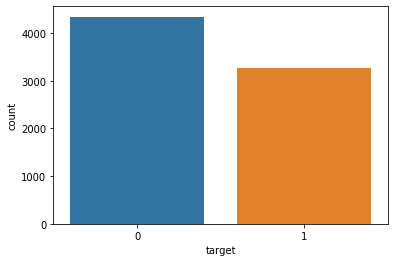

In [7]:
sns.countplot(data=train_df, x="target")

In [8]:
train_df['Text_len'] = train_df['text'].apply(lambda txt: len(txt))
train_df.head()

,id,keyword,location,text,target,Text_len
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,69
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,133
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,65
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,88


In [9]:
train_df.describe()

,id,target,Text_len
count,7613.000000,7613.00000,7613.000000
mean,5441.934848,0.42966,101.037436
std,3137.116090,0.49506,33.781325
min,1.000000,0.00000,7.000000
25%,2734.000000,0.00000,78.000000
50%,5408.000000,0.00000,107.000000
75%,8146.000000,1.00000,133.000000
max,10873.000000,1.00000,157.000000


In [10]:
train_df.shape

(7613, 6)

In [11]:
def make_folds(df:pd.DataFrame, k=5, stratified=False, save=False):
    df['fold'] = 0
    if stratified:
        cv = StratifiedKFold(n_splits=k)
    else:
        cv = KFold(n_splits=k)
        
    for index, (train_idx, test_idx) in enumerate(tqdm(cv.split(df), position=0, desc='Making folds for corss validation')):
        # print(index, train, test)
        df.loc[test_idx, 'fold'] = index
    df = df.sample(frac=1).reset_index(drop=True)
    if save :
        fn = os.path.join(config.working_dir, f'dataset_{k}_folds.csv')
        df.to_csv(fn)
        print(f'[INFO] Dataset saved to working directory as {fn}')
        
    return df

In [23]:
_ = make_folds(df=train_df, k=10, stratified=False, save=True)

Making folds for corss validation: 10it [00:00, 799.92it/s]

[INFO] Dataset saved to working directory as /kaggle/working/dataset_10_folds.csv


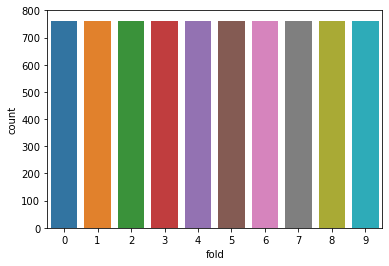

In [24]:
sns.countplot(data=train_df, x='fold')

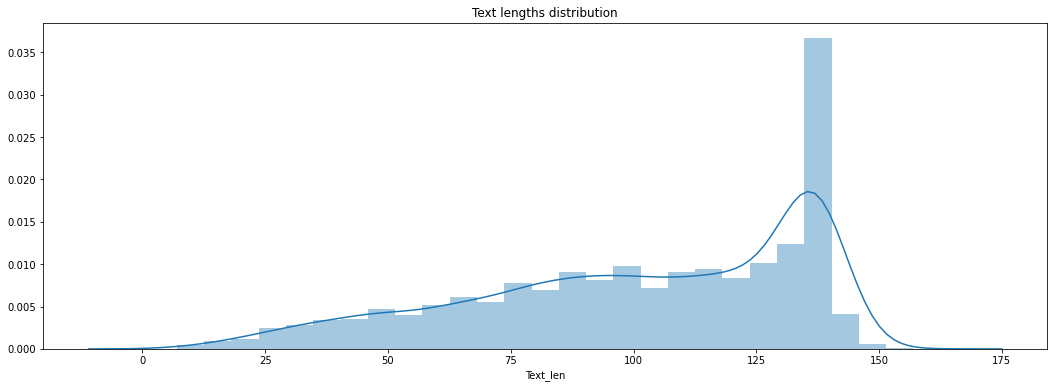

In [25]:
plt.figure(figsize=(18, 6))
sns.distplot(a=train_df['Text_len'])
plt.title('Text lengths distribution')
plt.show()

# Dataset & Dataloader

In [12]:
class DisasterDataset(Dataset):
    def __init__(self, df:pd.DataFrame, max_len:int, task='train'):
        super(DisasterDataset, self).__init__()
        self.task = task 
        self.max_len = max_len 
        self.df = df
        self.tokenizer = AutoTokenizer.from_pretrained(config.base_model)
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        text = self.df.iloc[index].text
        code = self.tokenizer.encode_plus(text=text, 
                                          return_tensors='pt', 
                                          truncation=True,
                                          max_length= self.max_len,
                                          padding='max_length'
                                         )
        
        sample = {
            'str' : text,
            'ids': code['input_ids'], 
            'attention_mask':code['attention_mask']
        }
        
        if self.task == "train":
            target = self.df.iloc[index].target
            sample.update({
                'targets': th.tensor([target], dtype=th.float)
            })
            
        return sample

In [13]:
train_dataset, validation_dataset = train_test_split(train_df, random_state=config.seed_value)

# using our custom dataset
train_ds = DisasterDataset(df=train_dataset, max_len = config.max_len, task='train')
val_ds = DisasterDataset(df=validation_dataset, max_len = config.max_len, task='train')

In [14]:
len(train_ds), len(val_ds)

(5709, 1904)

In [15]:
val_ds[15]

{'str': '@CalFreedomMom @steph93065 not to mention a major contributor to the annihilation of Israel',
 'ids': tensor([[  101,  1030, 19134,  9910,  9527,  5302,  2213,  1030,  3357,  2232,
           2683, 14142, 26187,  2025,  2000,  5254,  1037,  2350, 12130,  2000,
           1996,  5754, 19190, 29545,  1997,  3956,   102,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
          

In [16]:
# dataloaders
train_dl = DataLoader(dataset=train_ds, 
                      batch_size=config.train_batch_size, 
                      shuffle=True)


val_dl = DataLoader(dataset=val_ds, 
                      batch_size=config.test_batch_size, 
                      shuffle=True)

In [17]:
for data in val_dl:
    print(data['ids'].squeeze(1).shape, data['targets'].shape)
    break

torch.Size([16, 115]) torch.Size([16, 1])


# Modeling

* Create Lightning module
* use bert pretrained model as encoder
* adding decoder layer Linear(encoder_out, num_classes) -> (768, 2)
* compute F1 score (and in addition loss and accuracy)
* use optimizer to optimize metrics

In [18]:
base_model = AutoModel.from_pretrained(config.base_model)
base_model

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0): TransformerBlock(
        (attention): MultiHeadSelfAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(i

In [19]:
class DisasterTweetsClassifier(pl.LightningModule):
    def __init__(self, num_epochs:int, lr:float, freeze:bool, num_classes:int, dropout:float, len_train_ds:int, steps_per_epoch=None):
        super(DisasterTweetsClassifier, self).__init__()
        self.num_epochs = num_epochs
        if steps_per_epoch is None:
            self.steps_per_epoch = len_train_ds //config.train_batch_size
        else:
            self.steps_per_epoch = steps_per_epoch
            
        self.lr = lr
        self.freeze = freeze
        
        # model architecture
        self.dropout = dropout
        # encoder part
        self.encoder = AutoModel.from_pretrained(config.base_model)
        if self.freeze:
            # self.encoder.freeze()
            for p in self.encoder.parameters():
                p.requires_grad = False
        try:
            self.num_ftrs = self.encoder.transformer.layer[5].ffn.lin2.out_features
        except:
            self.num_ftrs = 768 # default output dim for all bert last layer
        
        self.dropout = nn.Dropout(p=self.dropout)
        self.num_classes = num_classes
    
        # classifier part
        self.classifier = nn.Linear(in_features=self.num_ftrs, out_features=self.num_classes)
        if self.num_classes > 2:
            self.loss_fn = nn.NLLLoss()
        else:
            self.loss_fn = nn.BCELoss()

        # optimization stuff
        self.warmup_steps = self.steps_per_epoch // 3
        self.total_steps = self.steps_per_epoch * self.num_epochs - self.warmup_steps
        

        
    
        
    def forward(self, ids, attention_mask):
        out = self.encoder(input_ids=ids, attention_mask=attention_mask)
        last_hidden_state = out[0]
        out = self.dropout(last_hidden_state[:, 0])
        out = self.classifier(out)
        
        if self.num_classes > 2:
            out = th.softmax(out, dim=1)
        else :
            out = th.sigmoid(out)
    
        return out
    
    def configure_optimizers(self):
       
        if self.freeze:
            opt = AdamW(self.classifier.parameters(),
                          lr = self.lr, 
                          eps = 1e-8, 
                          weight_decay = 0.01
                )
        else:
            opt = AdamW(self.parameters(),
              lr = self.lr, 
              eps = 1e-8, 
              weight_decay = 0.01
            )        


        scheduler = get_linear_schedule_with_warmup(
                    optimizer = opt, 
                    num_warmup_steps = self.warmup_steps,
                    num_training_steps = self.total_steps
        )

        return [opt], [scheduler]
    
    
    def training_step(self, batch, batch_idx):
        ids , attention_mask, targets = batch['ids'].squeeze(1), batch['attention_mask'].squeeze(1), batch['targets']
        
        preds = self(ids=ids, attention_mask=attention_mask)
        
        # loss
        loss = self.loss_fn(preds, targets)
        
        # f1
        f1_score = f1(preds = preds, target=targets, num_classes=self.num_classes)
        
        # precision
        precision_score = precision(pred=preds, target=targets, num_classes=self.num_classes)
        
        acc = accuracy(pred=preds, target=targets, num_classes=self.num_classes)
        
        #tb_logs = {'train_loss': loss, 'f1-score_train': f1_score, 'precision_train':precision_score}
        
        self.log('f1_train', f1_score, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        
        return {'loss' : loss, 
                'accuracy': acc,
                "predictions": preds, 
                'targets':targets, 
                "precision":precision_score, 
                "f1_score":f1_score}
    
    
    
    def training_epoch_end(self,outputs):
        #  the function is called after every epoch is completed

        # calculating average loss  
        avg_loss = th.stack([x['loss'] for x in outputs]).mean()
        # acc
        avg_acc = th.stack([x['accuracy'] for x in outputs]).mean()
        
        # calculating average precision  
        avg_precision = th.stack([x['precision'] for x in outputs]).mean()
        
        # calculating average f1  
        avg_f1 = th.stack([x['f1_score'] for x in outputs]).mean()
                
        # logging using tensorboard logger
        self.logger.experiment.add_scalar("Loss/Train",
                                            avg_loss,
                                            self.current_epoch)
        
        self.logger.experiment.add_scalar("Accuracy/Train",
                                            avg_acc,
                                            self.current_epoch)

        self.logger.experiment.add_scalar("F1/Train",
                                            avg_f1,
                                            self.current_epoch)
        
        self.logger.experiment.add_scalar("Precision/Train",
                                            avg_precision,
                                            self.current_epoch)


    
    def validation_step(self, batch, batch_idx):
        ids , attention_mask, targets = batch['ids'].squeeze(1), batch['attention_mask'].squeeze(1), batch['targets']
        
        preds = self(ids=ids, attention_mask=attention_mask)
        
        # loss
        loss = self.loss_fn(preds.detach().cpu(), targets.detach().cpu())
        
        # f1
        f1_score = f1(preds = preds.detach().cpu(), target=targets.detach().cpu(), num_classes=self.num_classes)
        
        # precision
        precision_score = precision(pred=preds.detach().cpu(), target=targets.detach().cpu(), num_classes=self.num_classes)
        
        acc = accuracy(pred=preds, target=targets, num_classes=self.num_classes)
        
        #tb_logs = {'train_loss': loss, 'f1-score_train': f1_score, 'precision_train':precision_score}
        
        self.log('f1_val', f1_score, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        
        return {'loss' : loss, 
                'accuracy': acc,
                "predictions": preds, 
                'targets':targets, 
                "precision":precision_score, 
                "f1_score":f1_score}
    
    def validation_epoch_end(self, outputs):
        #  the function is called after every epoch is completed

        # calculating average loss  
        avg_loss = th.stack([x['loss'] for x in outputs]).mean()
        # acc
        avg_acc = th.stack([x['accuracy'] for x in outputs]).mean()
        
        # calculating average precision  
        avg_precision = th.stack([x['precision'] for x in outputs]).mean()
        
        # calculating average f1  
        avg_f1 = th.stack([x['f1_score'] for x in outputs]).mean()
                
        # logging using tensorboard logger
        self.logger.experiment.add_scalar("Loss/Validation",
                                            avg_loss,
                                            self.current_epoch)
        
        self.logger.experiment.add_scalar("Accuracy/Validation",
                                            avg_acc,
                                            self.current_epoch)

        self.logger.experiment.add_scalar("F1/Validation",
                                            avg_f1,
                                            self.current_epoch)
        
        self.logger.experiment.add_scalar("Precision/Validation",
                                            avg_precision,
                                            self.current_epoch)



model = DisasterTweetsClassifier(num_epochs=config.num_epochs,
                                 lr=config.lr, 
                                 freeze=False,
                                 num_classes=config.num_classes,
                                 dropout = .3,
                                 len_train_ds=len(train_ds)).to('cuda')

model

model.total_steps

model.warmup_steps

for data in val_dl:
    out = model(ids = data['ids'].squeeze(1).to('cuda'), attention_mask=data['attention_mask'].squeeze(1).to('cuda'))
    loss = model.loss_fn(out, data['targets'].to('cuda'))

out.shape

out

loss

loss.detach().cpu()

# Training phase

In [20]:
# cross validation 
def run_fold(fold_num,num_epochs, dataset):
    th.cuda.empty_cache()
    # get data
    
    train_dataset = dataset[dataset.fold!=fold_num].reset_index(drop=True)
    validation_dataset = dataset[dataset.fold==fold_num].reset_index(drop=True)

    # using our custom dataset
    train_ds = DisasterDataset(df=train_dataset, max_len = config.max_len, task='train')
    val_ds = DisasterDataset(df=validation_dataset, max_len = config.max_len, task='train') 
    
    
    # dataloaders
    train_dl = DataLoader(dataset=train_ds, 
                          batch_size=config.train_batch_size, 
                          shuffle=True)


    val_dl = DataLoader(dataset=val_ds, 
                          batch_size=config.test_batch_size, 
                          shuffle=False)



    #create model
    net = DisasterTweetsClassifier(num_epochs=num_epochs,
                                 lr=config.lr, 
                                 freeze=False,
                                 num_classes=config.num_classes,
                                 dropout = .3,
                                 len_train_ds=len(train_ds))

    
    del train_ds
    del val_ds
    del train_dataset
    del validation_dataset
    
    # callbacks & loggers
    gpu_stats = GPUStatsMonitor(temperature=True)
    model_ckpt = ModelCheckpoint(filename=f'disasterTweetsClassifier-fold-{fold_num}', 
                                 monitor='f1_val',
                                 mode='max',
                                 dirpath=config.models_dir, 
                                )
    es = EarlyStopping(monitor='f1_val', 
                       patience=5, 
                       mode='max')
    
    tb_logger = TensorBoardLogger(
        save_dir=config.logs_dir,
        name=f'disasterTweetsClassifier-fold-{fold_num}'
    )

    Callbacks = [gpu_stats, model_ckpt, es]


    # create trainer
    trainer = Trainer(gpus=-1, max_epochs=num_epochs, callbacks=Callbacks, logger=tb_logger)
    # fit model 
    

    
    trainer.fit(model=net, train_dataloader=train_dl, val_dataloaders=val_dl)
    
    del net
    # return metrics
    return trainer.logged_metrics


# one way training
def run(num_epochs, dataset):
    th.cuda.empty_cache()

    # get data
    train_dataset, validation_dataset = train_test_split(dataset, 
                                                         random_state=config.seed_value, 
                                                         test_size=config.test_size)

    # using our custom dataset
    train_ds = DisasterDataset(df=train_dataset, max_len = config.max_len, task='train')
    val_ds = DisasterDataset(df=validation_dataset, max_len = config.max_len, task='train')    
    
    
    # dataloaders
    train_dl = DataLoader(dataset=train_ds, 
                          batch_size=config.train_batch_size, 
                          shuffle=True)


    val_dl = DataLoader(dataset=val_ds, 
                          batch_size=config.test_batch_size, 
                          shuffle=False)


    net = DisasterTweetsClassifier(num_epochs=num_epochs,
                                 lr=config.lr, 
                                 freeze=False,
                                 num_classes=config.num_classes,
                                 dropout = .3,
                                 len_train_ds=len(train_ds))
    
    del train_ds
    del val_ds
    # callbacks & loggers
    gpu_stats = GPUStatsMonitor(temperature=True)
    model_ckpt = ModelCheckpoint(filename=f'disasterTweetsClassifier-all', 
                                 monitor='f1_val',
                                 mode='max',
                                 dirpath=config.models_dir, 
                                )
    es = EarlyStopping(monitor='f1_val', 
                       patience=5, 
                       mode='max')
    
    tb_logger = TensorBoardLogger(
        save_dir=config.logs_dir,
        name=f'disasterTweetsClassifier-all'
    )

    Callbacks = [gpu_stats, model_ckpt, es]
    
    # create trainer
    trainer = Trainer(gpus=-1, max_epochs=num_epochs, callbacks=Callbacks, logger=tb_logger)

    # train model
    trainer.fit(model=net, train_dataloader=train_dl, val_dataloaders=val_dl)
    
    del net
    
    return trainer.logged_metrics



# training fn
def train_fn(num_epochs, dataset:pd.DataFrame, n_folds=0, device='cuda'):
    if n_folds > 0:
        print(f'\n[INFO] Training with {n_folds}-folds cross validation...\n')
        dataset = make_folds(df=dataset,stratified=False, save=False, k=n_folds)
        losses = []
        f1_val = []
        f1_train = []

        for fold_num in range(n_folds):
            print(f'[INFO] Runung fold {fold_num}')
            m = run_fold(fold_num, num_epochs, dataset)
            # print fold results 
            best_epoch = m['epoch']
            best_train_f1 = m['f1_train_epoch']
            best_val_f1 = m['f1_val']
            print(f'[INFO] Fold : {fold_num}')
            print(f'[INFO] Best Epoch : {best_epoch}')
            print(f'[INFO] Best Training f1 score : {best_train_f1}')
            print(f'[INFO] Best Validation f1 score : {best_val_f1}')
            # save fold metrics
            f1_train.append(best_train_f1)
            f1_val.append(best_val_f1)
            
    else:
        m = run(num_epochs, dataset)
    
    if len(f1_val) > 0:
        return (np.array(f1_val), np.array(f1_train), m)
    else:
        return m

In [23]:
m = train_fn(num_epochs=config.num_epochs, n_folds=config.n_folds, dataset=train_df)

0:09<00:02,  8.33it/s]
Epoch 5:  67%|██████▋   | 192/287 [01:54<00:56,  1.67it/s, loss=0.219, v_num=1, f1_train_step=1, f1_val=0.748, f1_train_epoch=0.875]
Validating: 0it [00:00, ?it/s]
Epoch 6:  13%|█▎        | 37/287 [00:22<02:33,  1.63it/s, loss=0.125, v_num=1, f1_train_step=0.929, f1_val=0.739, f1_train_epoch=0.909]
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

Traceback (most recent call last):
  File "/home/zeusdric/anaconda3/envs/pytorch-env/lib/python3.6/site-packages/pytorch_lightning/trainer/trainer.py", line 494, in train
    self.train_loop.run_training_epoch()
  File "/home/zeusdric/anaconda3/envs/pytorch-env/lib/python3.6/site-packages/pytorch_lightning/trainer/training_loop.py", line 561, in run_training_epoch
    batch_output = self.run_training_batch(batch, batch_idx, dataloader_idx)
  File "/home/zeusdric/anaconda3/envs/pytorch-env/lib/python3.6/site-packages/pytorch_lightning/trainer/training_loop.py", line

TypeError: object of type 'NoneType' has no len()

In [ ]:
! ls ../logs/

In [ ]:
def get_v0(ckpth_path):
    if len(ckpth_path.split('v0')) == 1:
        
        
        ckpth_path = ckpth_path.split('.')
        ckpth_path.insert(1, "-v0.")
        ckpth_path = ''.join(ckpth_path)
        return ckpth_path    
    
    else:
        pass
    

# Tensorboard

In [ ]:
%tensorboard --logdir ../logs/

# Inference Time

In [74]:
submission_df.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [78]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [84]:
! ls ../working/models/

disasterTweetsClassifier-all-v0.ckpt


In [75]:
os.listdir('../working/models')

['disasterTweetsClassifier-fold-4-v0.ckpt',
 'disasterTweetsClassifier-fold-1.ckpt',
 'disasterTweetsClassifier-fold-3.ckpt',
 'disasterTweetsClassifier-fold-2-v0.ckpt',
 'disasterTweetsClassifier-fold-0.ckpt']

In [83]:

def make_prediction(ckpt_dir, ids, attention_mask, k=0):
    if k > 0:
        preds = []
        models = os.listdir(ckpt_dir)
        
        for md in tqdm(models, position=0):
            ckpt = th.load(os.path.join(ckpt_dir, md))
        
            new_model = DisasterTweetsClassifier(num_epochs=config.num_epochs,
                                             lr=config.lr, 
                                             freeze=False,
                                             num_classes=config.num_classes,
                                             dropout = .3,
                                             len_train_ds=len(train_ds))    

            # load model weights
            new_model.load_state_dict(ckpt['state_dict'])
            new_model = new_model.to("cpu")
            new_model.eval()

            # predict
            pred =  new_model(ids=ids, attention_mask=attention_mask).detach().numpy().flatten()[0]
            preds.append(pred)

        pred = np.array(preds).mean()
    else:
        ckpt = th.load(ckpt_path)
        new_model = DisasterTweetsClassifier(num_epochs=config.num_epochs,
                                         lr=config.lr, 
                                         freeze=False,
                                         num_classes=config.num_classes,
                                         dropout = .3,
                                         len_train_ds=len(train_ds))    

        # load model weights
        new_model.load_state_dict(ckpt['state_dict'])
        new_model = new_model.to("cpu")
        new_model.eval()

        # predict
        pred =  new_model(ids=ids, attention_mask=attention_mask).detach().numpy().flatten()[0]
    
    return pred


def decode(pred):
    if pred >=.7:
        target = 1
    else:
        target = 0
        
    return target

In [235]:
def make_submission(batch_size=32):
    th.cuda.empty_cache()
    test_ds = DisasterDataset(df=test_df, max_len = config.max_len, task='test')
    test_dl =  DataLoader(dataset=test_ds, 
                          batch_size=batch_size, 
                          shuffle=False)

    total_preds = []

    for model in os.listdir(config.models_dir):
        print(model + ' is predicting on batch \n')
        ckpt_path =( os.path.join(config.models_dir, model))
        ckpt = th.load(ckpt_path)
        new_model = DisasterTweetsClassifier(num_epochs=config.num_epochs,
                                         lr=config.lr, 
                                         freeze=False,
                                         num_classes=config.num_classes,
                                         dropout = .3,
                                         len_train_ds=len(train_ds))    

        # load model weights
        new_model.load_state_dict(ckpt['state_dict'])
        new_model = new_model.to("cuda")
        new_model.eval()

        model_preds = []

        for bath_idx, batch in enumerate(tqdm(test_dl, position=0, desc='Predicting on test batch')) :
            preds = new_model(ids = batch['ids'].squeeze(1).to("cuda"), attention_mask=batch['attention_mask'].squeeze(1).to('cuda') )
            model_preds += preds.detach().cpu().numpy().flatten().tolist()

            del preds

        total_preds.append(model_preds)
        
        
    final_preds = np.array(total_preds).transpose().mean(axis=1)
    
    return [int(x > .70) for x in final_preds.tolist()]

In [239]:
predictions = make_submission(batch_size=32)

disasterTweetsClassifier-fold-4-v0.ckptis predicting on batch 



Predicting on test batch: 100%|██████████| 102/102 [00:09<00:00, 10.42it/s]


disasterTweetsClassifier-fold-1.ckptis predicting on batch 



Predicting on test batch: 100%|██████████| 102/102 [00:10<00:00, 10.04it/s]


disasterTweetsClassifier-fold-3.ckptis predicting on batch 



Predicting on test batch: 100%|██████████| 102/102 [00:09<00:00, 10.52it/s]


disasterTweetsClassifier-fold-2-v0.ckptis predicting on batch 



Predicting on test batch: 100%|██████████| 102/102 [00:10<00:00, 10.06it/s]


disasterTweetsClassifier-fold-0.ckptis predicting on batch 



Predicting on test batch: 100%|██████████| 102/102 [00:09<00:00, 10.43it/s]


In [ ]:
!nvidia-smi

In [237]:
submission_df.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [240]:
submission_df['target'] = predictions
submission_df.head()

,id,target
0,0,0
1,2,1
2,3,1
3,9,1
4,11,1


In [267]:
keys = vars(config)
fn = ""
for v in keys:
    if( '__' not in v and 'path' not in v and 'dir' not in v):
        fn+=f'{v}_{keys[v]}_'
        

submission_df.to_csv(os.path.join(config.working_dir, fn+'.csv'), index=False)

In [266]:
!ls ../working/

__notebook_source__.ipynb
dataset_10_folds.csv
logs
max_len_115_base_model_distilbert-base-uncased_train_batch_size_32_test_batch_size_16_lr_0.0003_num_epochs_10_n_folds_5_seed_value_2021_num_classes_1_num_workers_2_test_size_0.1_.csv
models


In [270]:
pd.read_csv(os.path.join(config.working_dir, fn+'.csv')).head()

,id,target
0,0,0
1,2,1
2,3,1
3,9,1
4,11,1
